# Cross Referencing Overview

![a](https://img.shields.io/badge/Subject:-Overview-blue)
![b](https://img.shields.io/badge/Difficulty:-Easy-green)
![c](https://img.shields.io/badge/Author:-Eliza_Diggins-green)

---

In this example, we're going learn the very basics of ``pyXMIP`` and get started processing data! The first step is to generate a ``SourceTable`` containing your catalog of novel sources. In this example, we're going to use the eROSITA x-ray survey (eRASS1). Let's go ahead and get started by downloading the hard band X-ray catalog [here](https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/MerloniA_DR1/eRASS1_Hard.tar.gz). Once it's been extracted, there should be a file ``eRASS1_Hard.v1.0.fits``.

In [1]:
import pyXMIP as pyxmip

catalog = pyxmip.SourceTable.read("data/eRASS1_Hard.v1.0.fits")

## Source Tables

---

Source tables are the bread and butter of ``pyXMIP``. The object ``catalog`` is a ``SourceTable`` containing our catalog of data. It works *just like* an ``Astropy`` table (it's actually a subclass of ``astropy.table.table.Table``). You can load and view data just like you would a standard table. The only major difference is that the ``SourceTable`` class has some additional structure for interfacing with ``pyxmip``.

Let's go ahead and have a look at the catalog!

In [2]:
catalog[:2]

IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_1B,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,ML_CTS_0,ML_CTS_ERR_0,ML_RATE_0,ML_RATE_ERR_0,ML_FLUX_0,ML_FLUX_ERR_0,DET_LIKE_0,ML_BKG_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,ML_RATE_UPERR_1,ML_FLUX_1,ML_FLUX_ERR_1,ML_FLUX_LOWERR_1,ML_FLUX_UPERR_1,DET_LIKE_1,ML_BKG_1,ML_EXP_1,ML_EEF_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_RADIUS_1,APE_POIS_1,ML_CTS_2,ML_CTS_ERR_2,ML_CTS_LOWERR_2,ML_CTS_UPERR_2,ML_RATE_2,ML_RATE_ERR_2,ML_RATE_LOWERR_2,ML_RATE_UPERR_2,ML_FLUX_2,ML_FLUX_ERR_2,ML_FLUX_LOWERR_2,ML_FLUX_UPERR_2,DET_LIKE_2,ML_BKG_2,ML_EXP_2,ML_EEF_2,APE_CTS_2,APE_BKG_2,APE_EXP_2,APE_RADIUS_2,APE_POIS_2,ML_CTS_3,ML_CTS_ERR_3,ML_CTS_LOWERR_3,ML_CTS_UPERR_3,ML_RATE_3,ML_RATE_ERR_3,ML_RATE_LOWERR_3,ML_RATE_UPERR_3,ML_FLUX_3,ML_FLUX_ERR_3,ML_FLUX_LOWERR_3,ML_FLUX_UPERR_3,DET_LIKE_3,ML_BKG_3,ML_EXP_3,ML_EEF_3,APE_CTS_3,APE_BKG_3,APE_EXP_3,APE_RADIUS_3,APE_POIS_3,FLAG_SP_SNR,FLAG_SP_BPS,FLAG_SP_SCL,FLAG_SP_LGA,FLAG_SP_GC_CONS,FLAG_NO_RADEC_ERR,FLAG_NO_EXT_ERR,FLAG_NO_CTS_ERR,FLAG_OPT
,,,,,,,deg,deg,deg,deg,arcsec,arcsec,arcsec,arcsec,,,deg,deg,deg,deg,,,,arcsec,arcsec,arcsec,arcsec,,ct,ct,ct / s,ct / s,erg / (s cm2),erg / (s cm2),,1 / arcmin2,ct,ct,ct,ct,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),,1 / arcmin2,s,,ct,ct,s,pix,,ct,ct,ct,ct,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),,1 / arcmin2,s,,ct,ct,s,pix,,ct,ct,ct,ct,ct / s,ct / s,ct / s,ct / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),,1 / arcmin2,s,,ct,ct,s,pix,,,,,,,,,,
bytes23,bytes32,int32,int32,int64,int64,int32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16
1eRASS J002937.2-310209,eb01_009120_020_ML00004_002_c010,9120,4,200912000004,100912000003,2,7.405289537904334,-31.03614030207814,7.405710240663302,-31.035649025952413,0.82363707,0.89143175,0.72284317,0.70867616,1.3288999,1.2127368,352.2853356989763,-83.83855886476962,353.0381747433981,-31.12811463243855,59002.516,59002.18,59003.016,0.0,0.0,0.0,0.0,0.0,185.8658,14.140073,1.7458236,0.13315687,2.3793383e-12,3.3537748e-13,804.7264,0.86742705,71.3996,8.685286,8.302305,9.068266,0.6585198,0.08010455,0.076572314,0.08363679,6.4058345e-13,7.7922715e-14,7.448669e-14,8.135875e-14,317.0371,0.24357267,108.42437,0.8923024,53,0.010303371,108.42077,6.9726653,0.0,106.88764,10.782217,10.351733,11.2127,0.9926084,0.10012869,0.09613102,0.10412636,9.131632e-13,9.2114704e-14,8.8436996e-14,9.579241e-14,469.87323,0.4039116,107.68359,0.8836025,82,0.24397036,107.67999,7.6028023,0.0,7.5785737,2.8725004,2.52698,3.218021,0.09469535,0.0358923,0.031574972,0.04020963,8.2559155e-13,3.1292327e-13,2.752831e-13,3.5056346e-13,27.58704,0.2199428,80.031105,0.85624605,7,0.3352769,80.032265,9.822519,7.0516265e-08,0,0,0,0,0,0,0,0,0
1eRASS J004207.0-283154,eb01_012120_020_ML00002_002_c010,12120,2,201212000002,101212000001,1,10.529647881881871,-28.531489952085423,10.530207214790638,-28.531000223134942,5.532097,5.67905,5.368263,5.282485,6.454393,7.927478,358.13455660340344,-87.50797579930084,357.1710097385407,-30.137857888088625,59006.34

We can see all of the various columns in the ``SourceTable`` have come through, and that most have all of the relevant meta data as well. 

The next step is to tell ``pyxmip`` what each of our columns "means!"

## Schema
---

For many of the classes in ``pyXMIP``, there are corresponding ``Schema`` classes which serve the role of "converting" information in a catalog to a form that ``pyXMIP`` understands (standardization).

In many cases, you can get away without specifying a schema explicitly because ``pyXMIP`` will try to auto-generate it for you. This is the case for us:

In [3]:
catschema = catalog.schema

pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,351  [SourceTableSchema] Constructing SourceTableSchema from fits table.
pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,352  [SourceTableSchema] Failed to identify automatic match for special column Z.
pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,353  [SourceTableSchema] Failed to identify automatic match for special column TYPE.
pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,354  [SourceTableSchema] Identified special key NAME with column IAUNAME of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,355  [SourceTableSchema] Identified special key RA with column RA of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,356  [SourceTableSchema] Identified special key DEC with column DEC of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,357  [SourceTableSchema] Identified special key L with column LII of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:47:54,358  [SourceTableSchema] Identified special key B with column BII of the table.
pyXMIP : [DEBUG    ] 20

As you can see, ``pyXMIP`` was able to construct a schema just based on the column names. In general, a schema is functional for a source table if there is at least

- 1 set of detected coordinates.
  - In this case, we found two: RA/DEC and L/B.
- A match for the ``NAME`` column
  - In this case, we autodetect ``IAUNAME`` in the catalog.

The additional schema columns are useful in some cases, but not universally necessary. We highly recommend reading the more in-depth guide on ``Schema`` classes! In this case, everything has gone well and we can proceed.

Let's take a moment to visualize our catalog:

Text(0.5, 0, 'RA')

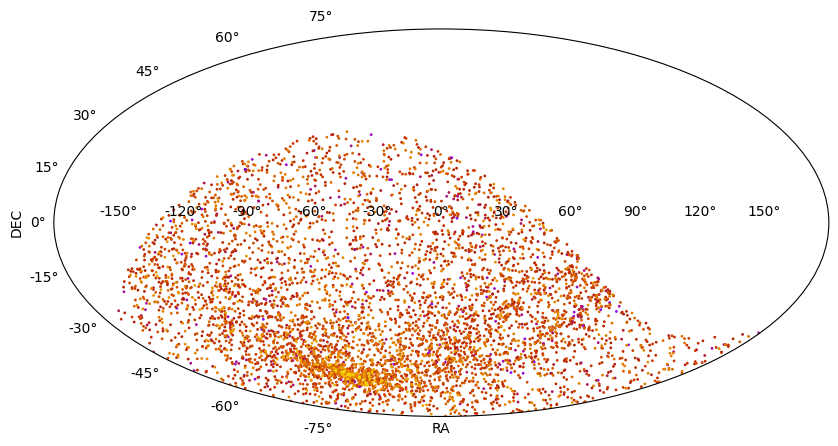

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# -- create the figure -- #
figure = plt.figure(figsize=(10, 7))
ax = figure.add_subplot(111, projection="aitoff")

# -- pull the latitute longitude, and rate -- #
lat, lon = catalog.lat.to_value("rad"), catalog.lon.to_value("rad")
rate = catalog["ML_RATE_0"]

# -- plot -- #
ax.scatter(lon - np.pi, lat, 1, c=np.log10(rate), cmap="gnuplot_r")

ax.set_ylabel("DEC")
ax.set_xlabel("RA")

We can also visualize in galactic coordinates:

Text(0.5, 0, '$l$')

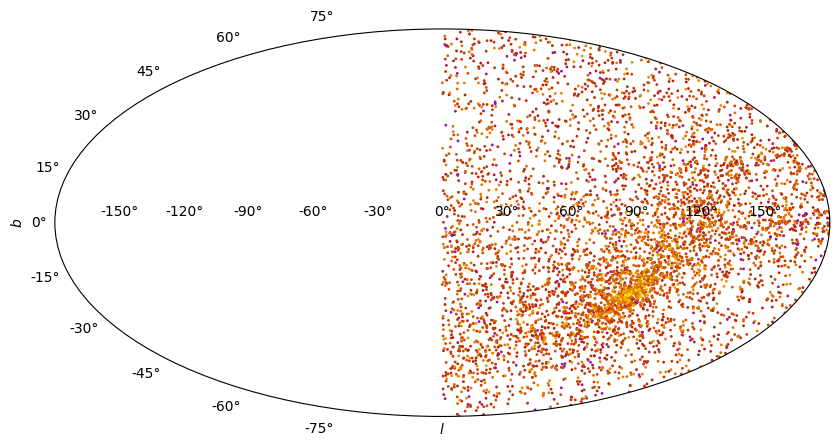

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# -- create the figure -- #
figure = plt.figure(figsize=(10, 7))
ax = figure.add_subplot(111, projection="aitoff")

# -- pull the latitute longitude, and rate -- #
coordinates = catalog.get_coordinates().transform_to("galactic")

lat, lon = coordinates.frame.spherical.lat.rad, coordinates.frame.spherical.lon.rad

rate = catalog["ML_RATE_0"]

# -- plot -- #
ax.scatter(lon - np.pi, lat, 1, c=np.log10(rate), cmap="gnuplot_r")

ax.set_ylabel(r"$b$")
ax.set_xlabel(r"$l$")

## Databases

---

In order to cross-match our catalog, we have to first find location matches in external databases. ``pyXMIP`` makes this process simple by standardizing the backend-API for referencing these external databases.

Each of the external databases supported is represented as a ``Database`` class in ``pyxmip.structures.databases``. All of these available databases are also listed in a ``DBRegistry`` (just a list of available databases). Let's see what databases are available to use right now:

In [6]:
from pyXMIP.structures.databases import DEFAULT_DATABASE_REGISTRY

for k, v in DEFAULT_DATABASE_REGISTRY.items():
    print(f"Database {k} is in class {v.__name__}")

Database NED is in class NED
Database SIMBAD is in class SIMBAD


If you want to use a separate database, that's easy to do: we recommend reading the documentation on databases to get started!

For this overview, we're going to use just the two databases we've included in this example. Let's go ahead and cross-match!

In [8]:
from pyXMIP.cross_reference import cross_match

cross_match(
    "data/eRASS1_Hard.v1.0.fits",
    "data/cross_matched.db",
    overwrite=True,
    thread=True,
    thread_kw=dict(max_workers=20),
)

pyXMIP : [INFO     ] 2024-04-26 14:50:25,651 X-Matching data/eRASS1_Hard.v1.0.fits into data/cross_matched.db.
pyXMIP : [INFO     ] 2024-04-26 14:50:25,736 Cross matching with 2 databases: ['NED', 'SIMBAD'].
pyXMIP : [WARNING  ] 2024-04-26 14:50:25,738 Table NED_MATCH exists in data/cross_matched.db. Overwrite = True -> deleting.
pyXMIP : [WARNING  ] 2024-04-26 14:50:27,007 Table SIMBAD_MATCH exists in data/cross_matched.db. Overwrite = True -> deleting.


Matching from 2 databases:   0%|          | 0/2 [00:00<?, ?it/s]

pyXMIP : [INFO     ] 2024-04-26 14:50:27,090 Source matching 5466 against NED.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,092  [SourceTableSchema] Constructing SourceTableSchema from fits table.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,092  [SourceTableSchema] Failed to identify automatic match for special column Z.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,093  [SourceTableSchema] Failed to identify automatic match for special column TYPE.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,094  [SourceTableSchema] Identified special key NAME with column IAUNAME of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,094  [SourceTableSchema] Identified special key RA with column RA of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,095  [SourceTableSchema] Identified special key DEC with column DEC of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,096  [SourceTableSchema] Identified special key L with column LII of the table.
pyXMIP : [DEBUG    ] 2024-04-26 14:50:27,097  [SourceTableSchema]

Querying NED:   0%|          | 0/5466 [00:00<?, ?it/s]

pyXMIP : [INFO     ] 2024-04-26 14:53:30,164 Source matching 5466 against SIMBAD.
pyXMIP : [DEBUG    ] 2024-04-26 14:53:30,168 Querying with threading.


Querying SIMBAD:   0%|          | 0/5466 [00:00<?, ?it/s]

Okay! So what just happened? You'll see that we've made a new file: ``data/cross_matched.db``. This is a ``CrossMatchDatabase`` object that we can load into ``pyXMIP``.

In [11]:
from pyXMIP.cross_reference import CrossMatchDatabase

# Load the cross matching database
cmd = CrossMatchDatabase("data/cross_matched.db")

# Attributes
print(cmd)
print(cmd.tables)

<CrossMatchDatabase @ data/cross_matched.db>
['NED_MATCH', 'SIMBAD_MATCH']


## Cross Match Databases
---

``CrossMatchDatabases`` are one of the most important classes in the software. They wrap sql-databases containing all of our match data to easy interactions. You can query them for information about the tables within, and (most importantly) you can use various ``ReductionProcesses`` to identify the best source for a given object.